##  Visualizing coefficients on map

In [1]:
state='NY'
meas='SNWD'

### Load the required libraries

In [2]:
import pandas as pd
import numpy as np
import sklearn as sk
import urllib
import math

import numpy as np
from lib.numpy_pack import packArray,unpackArray
from lib.spark_PCA import computeCov
from lib.computeStatistics import *

from pickle import dump,load


In [3]:
#sc.stop()

In [4]:
%%time
%run lib/startup.py

172.17.0.2
sparkContext= <SparkContext master=local[2] appName=pyspark-shell>



/usr/local/spark/python/pyspark/sql/context.py:113: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


    pandas as    pd 	version=2.0.3 	required version>=0.19.2

     numpy as    np 	version=1.24.4 	required version>=1.12.0

   sklearn as    sk 	version=1.3.1 	required version>=0.18.1

module urllib has no version
   pyspark as pyspark 	version=3.5.0 	required version>=2.1.0

ipywidgets as ipywidgets 	version=8.1.1 	required version>=6.0.0

version of ipwidgets= 8.1.1
measurements is a Dataframe (and table) with 12720632 records
stations is a Dataframe (and table) with 119503 records
weather is a Dataframe (and table) which is a join of measurements and stations with 12720632 records
CPU times: user 1.11 s, sys: 557 ms, total: 1.66 s
Wall time: 45.8 s


In [5]:
sc

<SparkContext master=local[2] appName=pyspark-shell>

In [6]:
%%time
ms=[meas]
cms='or\n'.join(['Measurement="%s" '%(m) for m in ms])

##  read all data for state
Query="""
SELECT *
FROM weather
WHERE state="%s" and  measurement='%s'
"""%(state,meas)
print(Query)

weather_df=sqlContext.sql(Query) #weather_df contains the information for the state
print('number of rows in result=',weather_df.count())
weather_df.show(1)


SELECT *
FROM weather
WHERE state="NY" and  measurement='SNWD'

number of rows in result= 27002
+-----------+-----------+----+--------------------+--------+---------+---------+----------+----------------+-----+-------------+
|    Station|Measurement|Year|              Values|latitude|longitude|elevation|dist2coast|            name|state|      country|
+-----------+-----------+----+--------------------+--------+---------+---------+----------+----------------+-----+-------------+
|US1NYDT0024|       SNWD|2022|[00 00 00 00 00 0...| 42.0097| -73.8642|     65.8|    108.25|RED HOOK 1.2 NNE|   NY|United States|
+-----------+-----------+----+--------------------+--------+---------+---------+----------+----------------+-----+-------------+
only showing top 1 row

CPU times: user 16.6 ms, sys: 8.59 ms, total: 25.2 ms
Wall time: 13.4 s


In [7]:
pkl_filename=parquet_root+'/weather-statistics/'+state+'-'+','.join(ms)+'.pkl'
!ls $pkl_filename 

../Data/Weather/weather/datasets//weather-statistics/NY-SNWD.pkl


In [8]:
stat=load_or_compute_statistics(sqlContext,pkl_filename,weather_df,ms)
STAT=stat
STAT.keys()

precomputed statistics file exists


dict_keys(['SNWD'])

### compute spectral decomposition

In [9]:
%%time
#get mean and eigenvectors for measurement m
EigVec=STAT[meas]['eigvec']
Mean=STAT[meas]['Mean']
EigVec.shape

CPU times: user 29 µs, sys: 13 µs, total: 42 µs
Wall time: 54.4 µs


(366, 366)

In [10]:
%%time
decomp_parquet=parquet_root+'weather-statistics/'+state+'-'+meas+'.parquet'
if os.path.isdir(decomp_parquet):
    print('reading',decomp_parquet)
    decomposition=sqlContext.read.parquet(decomp_parquet)
    print('number of rows=',decomposition.count())
else:
    print('Computing',decomp_parquet)
    k=5
    decomposition=decompose_dataframe(sqlContext,weather_df,EigVec[:,:k],Mean).cache() # Make it possible to generate only first k coefficients.
    print('number of rows=',decomposition.count())
    print('saving to',decomp_parquet)
    decomposition.write.parquet(decomp_parquet)

reading ../Data/Weather/weather/datasets/weather-statistics/NY-SNWD.parquet
number of rows= 27002
CPU times: user 0 ns, sys: 17 ms, total: 17 ms
Wall time: 3.3 s


In [11]:
','.join(decomposition.columns)

'Station,Measurement,Year,Values,latitude,longitude,elevation,dist2coast,name,state,country,total_var,res_mean,res_1,coeff_1,res_2,coeff_2,res_3,coeff_3,res_4,coeff_4,res_5,coeff_5'

## Compute the count and average of `coeff_i` for each station.

In [12]:
feature='coeff_1'
df1 = decomposition.select('station','latitude','longitude','elevation','dist2coast',feature)
df1.show(2)

+-----------+--------+---------+---------+----------+-------------------+
|    station|latitude|longitude|elevation|dist2coast|            coeff_1|
+-----------+--------+---------+---------+----------+-------------------+
|US1NYDT0024| 42.0097| -73.8642|     65.8|    108.25|-1005.6747889586908|
|US1NYHR0016| 43.0088| -75.0539|    160.9|   251.125| -371.5902129023231|
+-----------+--------+---------+---------+----------+-------------------+
only showing top 2 rows



In [13]:
df2=df1.groupby(['station','latitude','longitude','elevation','dist2coast'])\
.agg({"station": "count", feature: "mean"})
#df2=df1.groupby(['station']).agg({"station": "count", feature: "mean"})
pdf=df2.toPandas()
pdf.sort_values(by=['station'],inplace=True)
pdf.head(5)

,station,latitude,longitude,elevation,dist2coast,count(station),avg(coeff_1)
386,US1NYAB0001,42.6670,-74.0509,445.0,178.625,16,-244.559693
153,US1NYAB0006,42.7198,-73.9304,88.7,177.375,12,-164.594193
1242,US1NYAB0010,42.5455,-74.1475,488.3,170.375,15,16.933731
1479,US1NYAB0016,42.7590,-73.7370,104.2,174.125,1,1.640123
858,US1NYAB0021,42.6918,-73.8311,79.2,172.875,13,-749.824636


In [14]:
# Find long/lat bounding box
max_long=pdf['longitude'].max()
min_long=pdf['longitude'].min()
max_lat=pdf['latitude'].max()
min_lat=pdf['latitude'].min()


In [15]:
#define a mapping from the range of the value to hex colors.
from matplotlib.colors import rgb2hex
_avg='avg(%s)'%feature
_min=pdf[_avg].min()
_max=pdf[_avg].max()
_min,_max

(-1404.9184527497246, 4639.238376734461)

In [16]:
import pylab as plt
cmap=plt.get_cmap('jet')
def get_color(val):
    x=(val-_min)/(_max-_min)
    return(rgb2hex(cmap(x)[:3]))

## Map
* Each circle is centered at a station.  
* The area of the circle corresponds to the number of years SNWD was recorded at the station.  
* The color fill of the circle corresponds to the value of `avg(coeff_1)` defined by color-bar.

In [18]:
!pip install ipyleaflet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 7.6 MB/s eta 0:00:00:00:0100:01


In [19]:
import ipyleaflet
#%pylab inline

from ipyleaflet import (
    Map,
    Marker,
    TileLayer, ImageOverlay,
    Polyline, Polygon, Rectangle, Circle, CircleMarker,
    GeoJSON,
    DrawControl,
    basemaps, basemap_to_tiles
)

### Basemaps

Basemaps are served in real time by map providers. There are many options. see here: https://ipyleaflet.readthedocs.io/en/latest/map_and_basemaps/basemaps.html

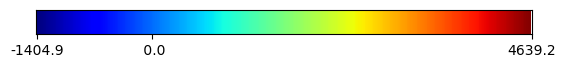

In [20]:
#def color_bar(_min,_max)
import pylab as plt
from matplotlib.pyplot import xticks,yticks
#figure(figsize=[10,1])

vals=cmap(np.arange(0,1,0.005))[:,:3]
vals3=np.stack([vals]*10)

ax = plt.subplot(111)
ax.imshow(vals3);

midpoint=200.*-_min/(_max-_min)
xticks((0,midpoint,200),["%4.1f"%v for v in (_min,0.,_max)])
yticks(());


center = [(min_lat+max_lat)/2, (min_long+max_long)/2]


zoom = 6

m = Map(basemap=basemaps.OpenTopoMap,default_tiles=TileLayer(opacity=1.0), center=center, zoom=zoom)
# basemap=basemaps.OpenTopoMap,

r = Rectangle(bounds=[[min_lat,min_long],[max_lat,max_long]], weight=5, fill_opacity=0.0)
m += r

lat_margin=(max_lat-min_lat)/4
long_margin=(max_long-min_long)/4
circles = []
for index,row in pdf.iterrows():
    _lat=row['latitude']
    _long=row['longitude']
    _count=row['count(station)']
    _coef=row[_avg]
    # taking sqrt of count so that the  area of the circle corresponds to the count
    c = Circle(location=(_lat,_long), radius=int(1200*np.sqrt(_count+0.0)), weight=1,
            color='#F00', opacity=0.8, fill_opacity=0.4,
            fill_color=get_color(_coef))
    circles.append(c)
    m.add_layer(c)

Map(center=[42.392399999999995, -75.8394], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in…

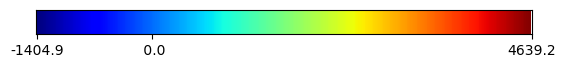

In [21]:
ax = plt.subplot(111)
ax.imshow(vals3);   
midpoint=200.*-_min/(_max-_min)
xticks((0,midpoint,200),["%4.1f"%v for v in (_min,0.,_max)])
yticks(());

m    

### Is coef_1 related to elevation ?

(-100.0, 1000.0)

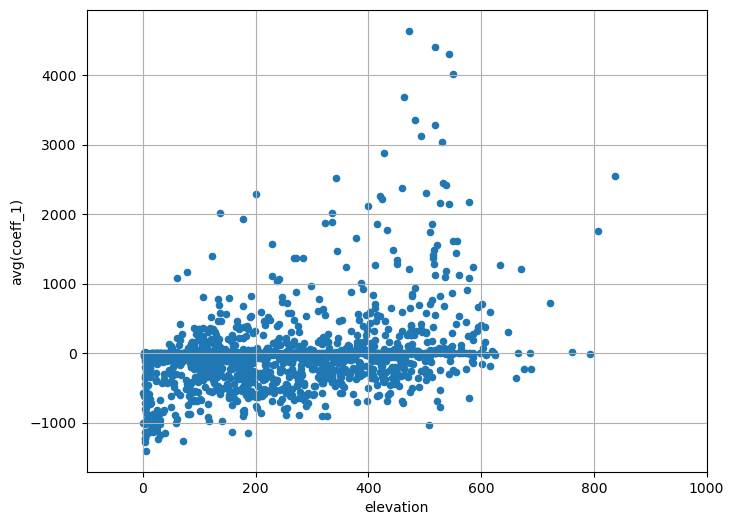

In [22]:
pdf.plot.scatter(x='elevation',y='avg(%s)'%feature,figsize=(8,6));
plt.grid()
plt.xlim([-100,1000])

### Is coef_1 related to latitude ?

(40.0, 45.2)

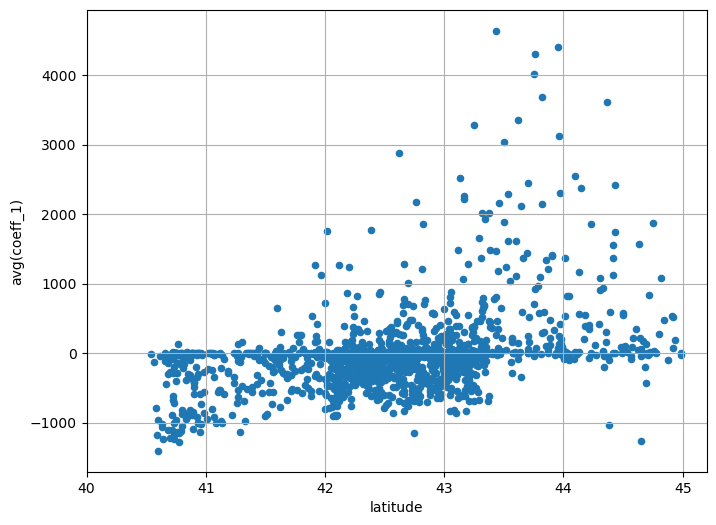

In [23]:
pdf.plot.scatter(x='latitude',y='avg(%s)'%feature,figsize=(8,6));
plt.grid()
plt.xlim([40,45.2])

### Is latitude related to elevation

(0.0, 1000.0)

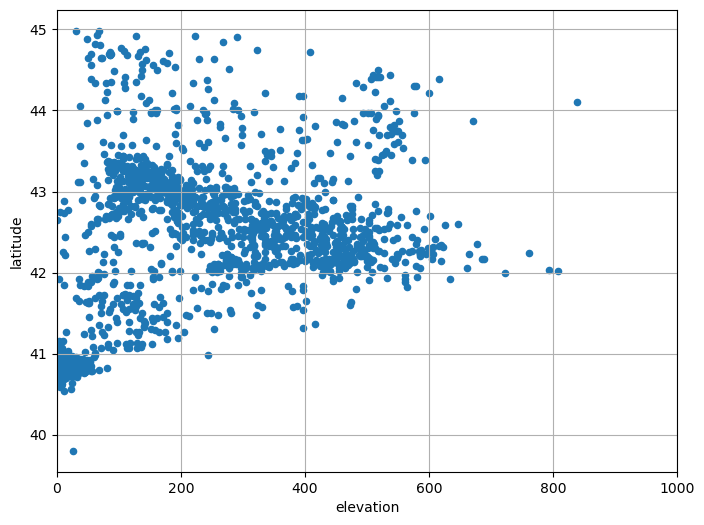

In [24]:
pdf.plot.scatter(x='elevation',y='latitude',figsize=(8,6));
plt.grid()
plt.xlim([0,1000])

## Summary
* We saw how to use `ipyLeaflet` to present data on top of maps.
* We saw that in NY state, most of the snow accumulation is in the Adirondacks.
* Snow accumulation increases with elevation, but the relationship is weak: locations with elevation 400-600 meters have widely varying accumulations of snow.